In [1]:
import os
import sys
import json
import glob
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import seaborn as sns
import networkx as nx

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import datetime

sys.path.append("../python/")

from plotutils import *
from metricutils import *

In [2]:
project_root  = "../"

layer = "cnig_provincias"
base_folder = f"TE_{layer}"
base_folder = os.path.join(project_root, f"outputs/{base_folder}")
config_fname= os.path.join(base_folder, "config.json")

with open(config_fname) as fh:
    config = json.load(fh)

geojson_fname  = f"../data/cnig_provincias.geojson"
gdf_patches = gpd.read_file(geojson_fname)
gdf_patches.set_index('id', inplace=True)
gdf_patches['centroid'] = gdf_patches['geometry'].apply(lambda x: x.centroid)
gdf_patches = gdf_patches[~gdf_patches.index.isin(config['filter_patches'])]
gdf_patches = gdf_patches.sort_index()

prov_names=dict(zip(gdf_patches.index,gdf_patches.name))

In [3]:
best_delta = 7 #best.delta
best_omega = 14 #best.omega
print(best_delta, best_omega)

# te_folder = os.path.join(base_folder, f"run_w{best_omega}_d{best_delta}_R_risk_ij/")
te_folder = os.path.join(base_folder, "run_ETE_w28_d14_S_Q1_-1_Q2_1_risk_ij")
Txy = xr.load_dataarray(os.path.join(te_folder, "TE.nc"))
DIxy = calculate_TSxy(Txy)

params_fname = os.path.join(te_folder,"params.json")
with open(params_fname) as fh:
    params = json.load(fh)
omega = params["te_params"]["omega"]
delta = params["te_params"]["delta"]

cases_ds = xr.open_dataset(os.path.join(base_folder, "cases_pop_ds.nc"))
risk_ds = xr.open_dataset(os.path.join(base_folder, "risk_ds.nc"))
cases_var = "new_cases_by_100k"

df_cases = cases_ds[cases_var].to_pandas().unstack()
df_cases.name = cases_var

7 14


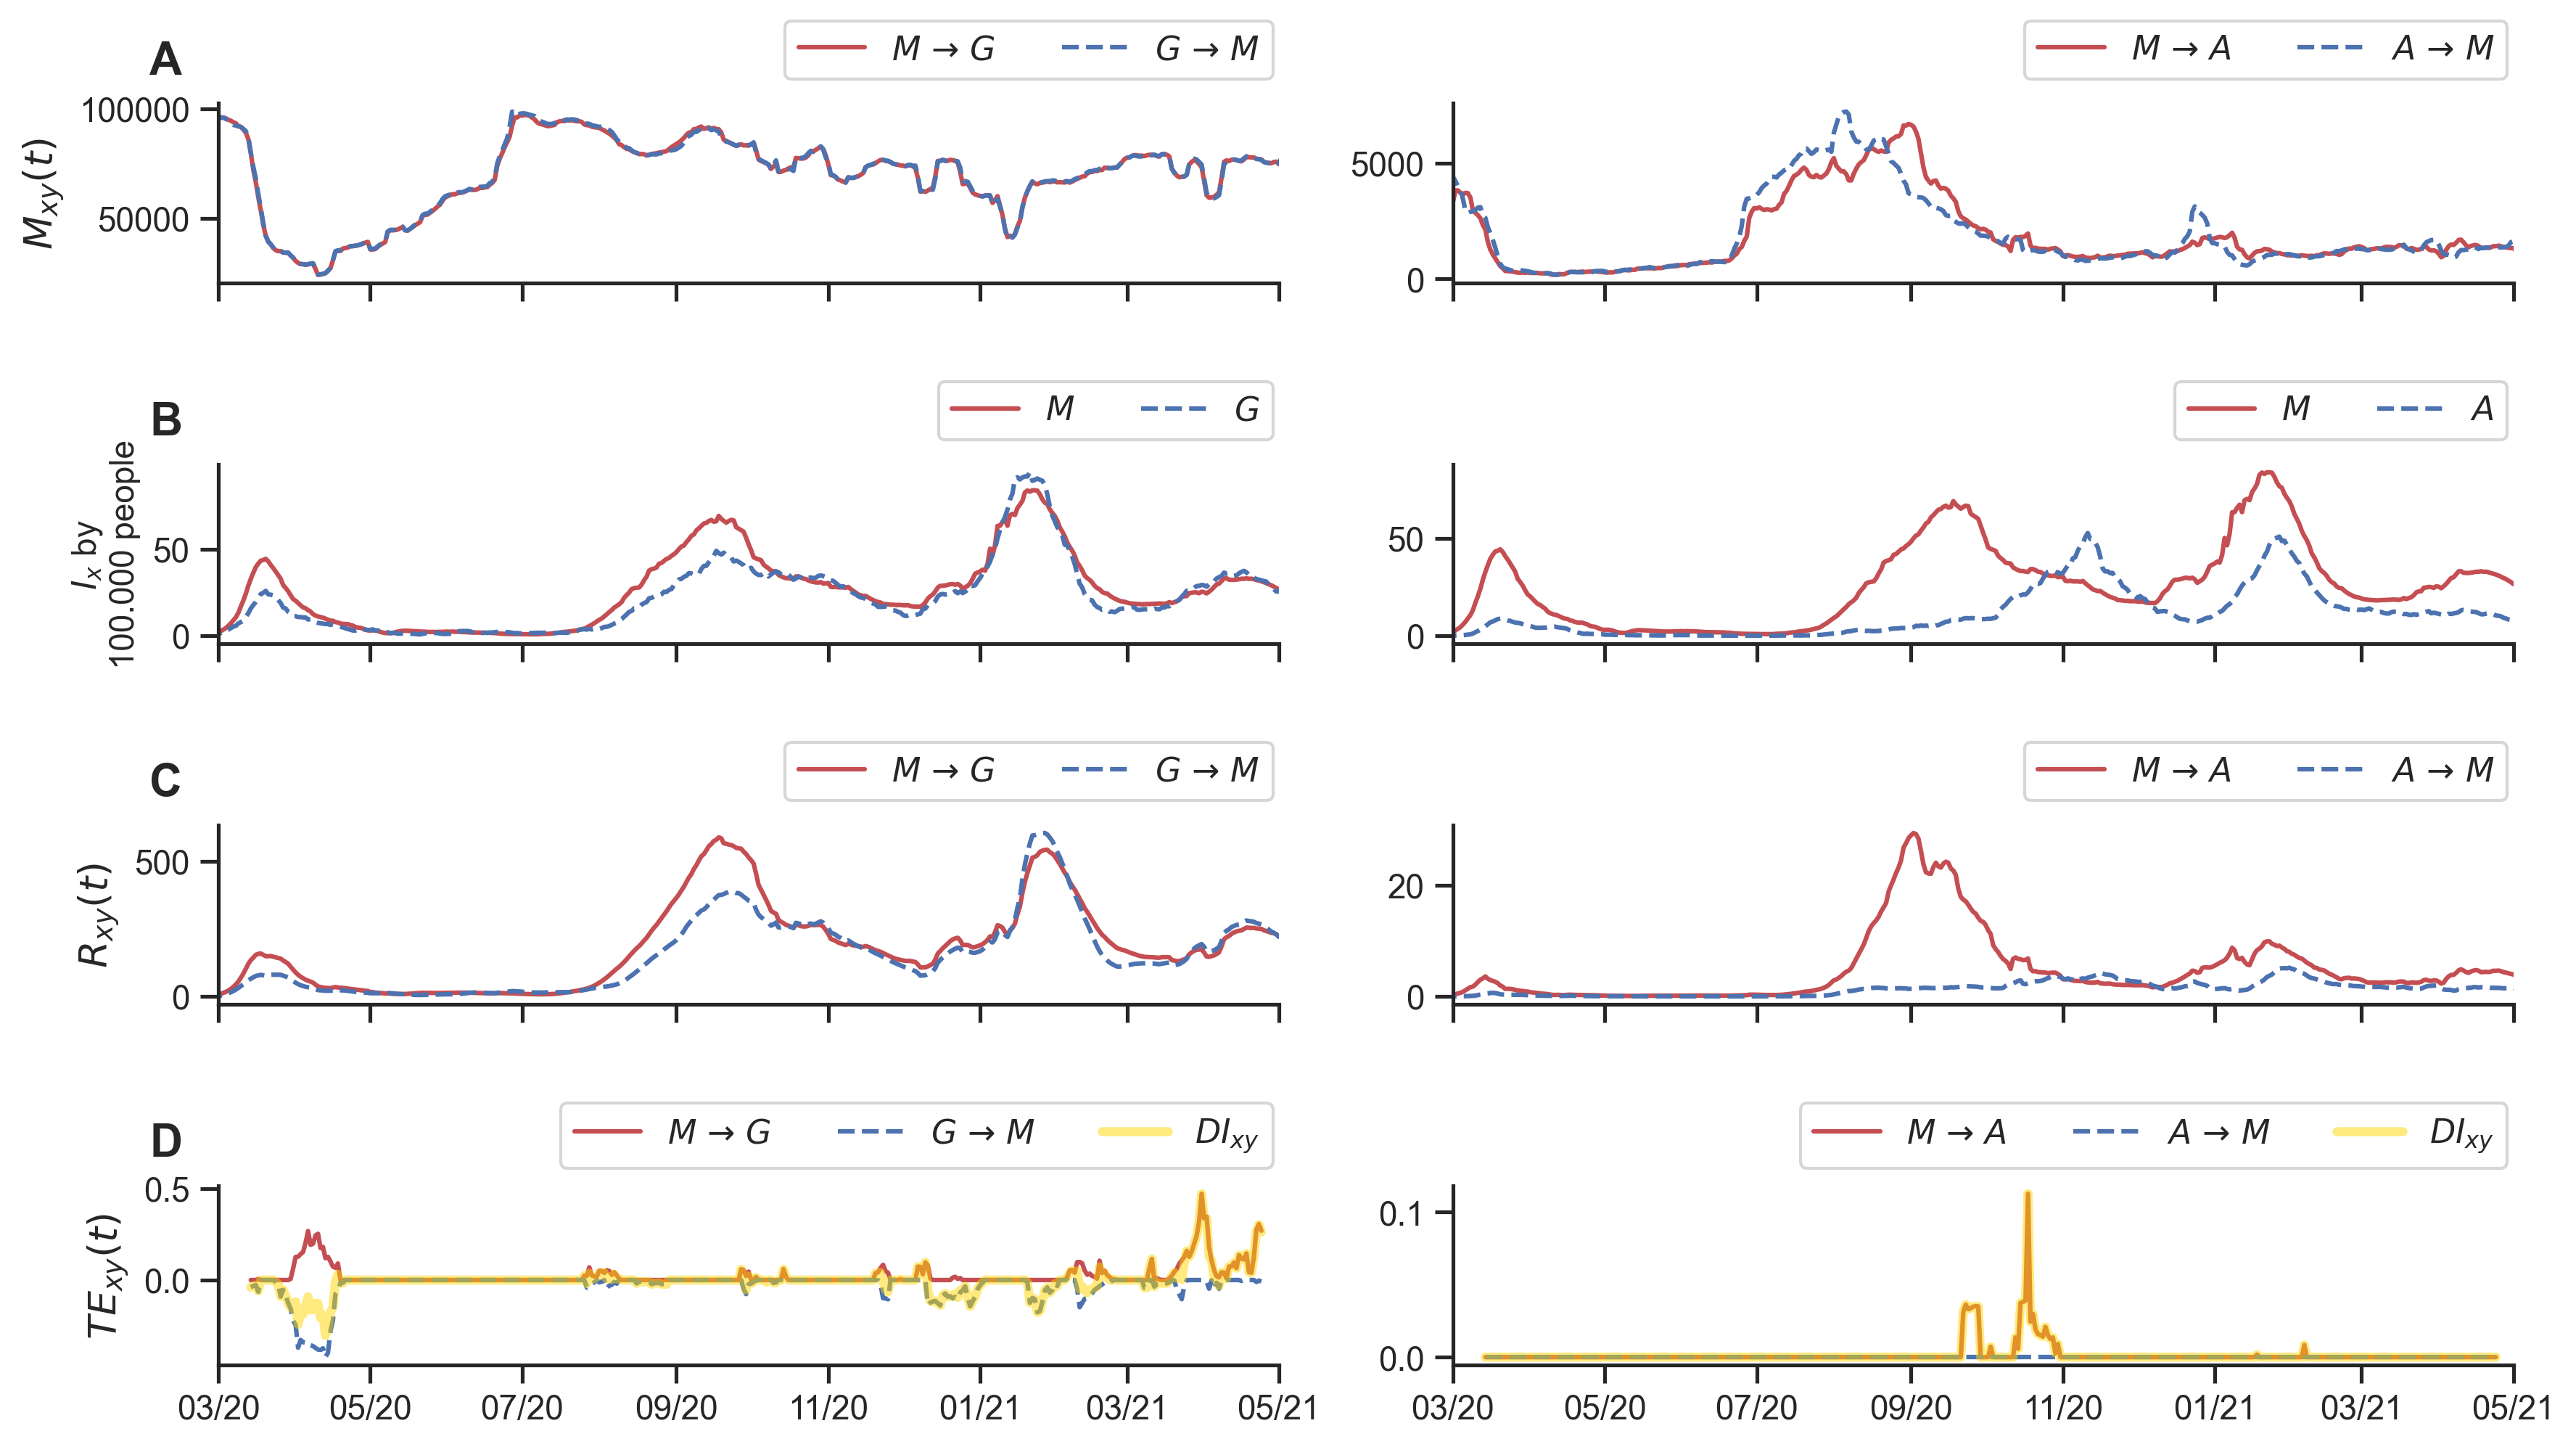

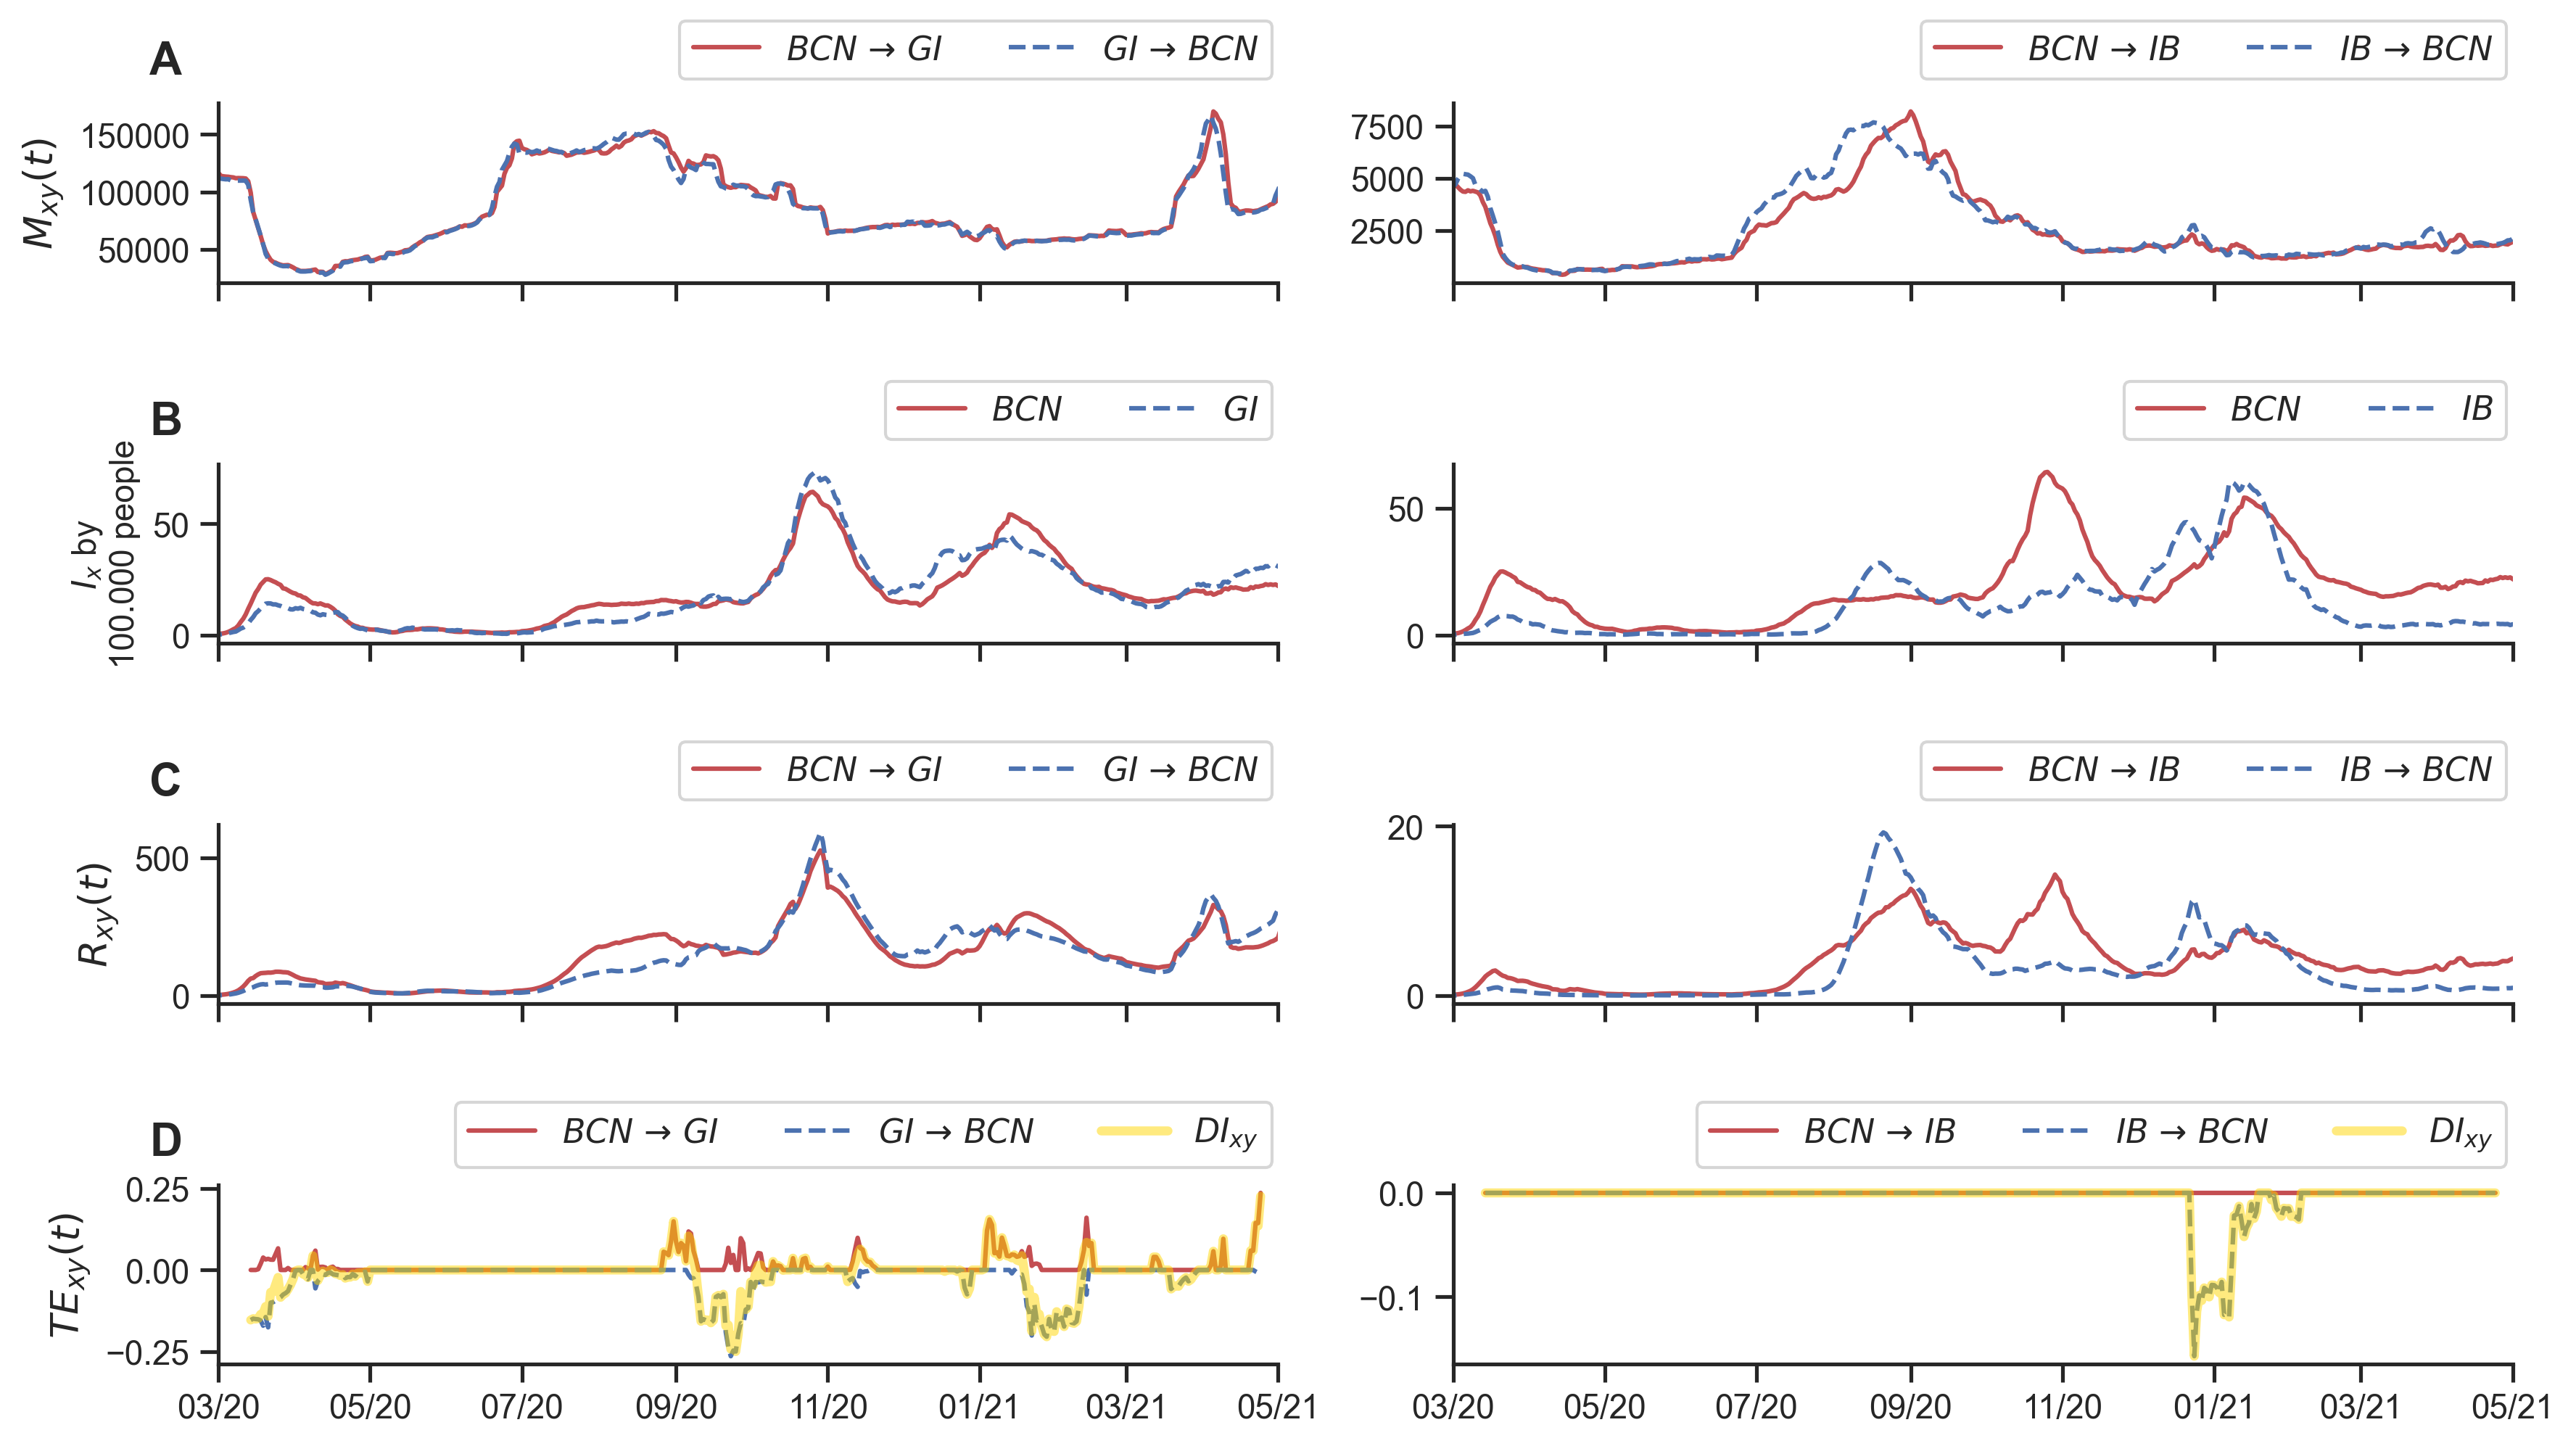

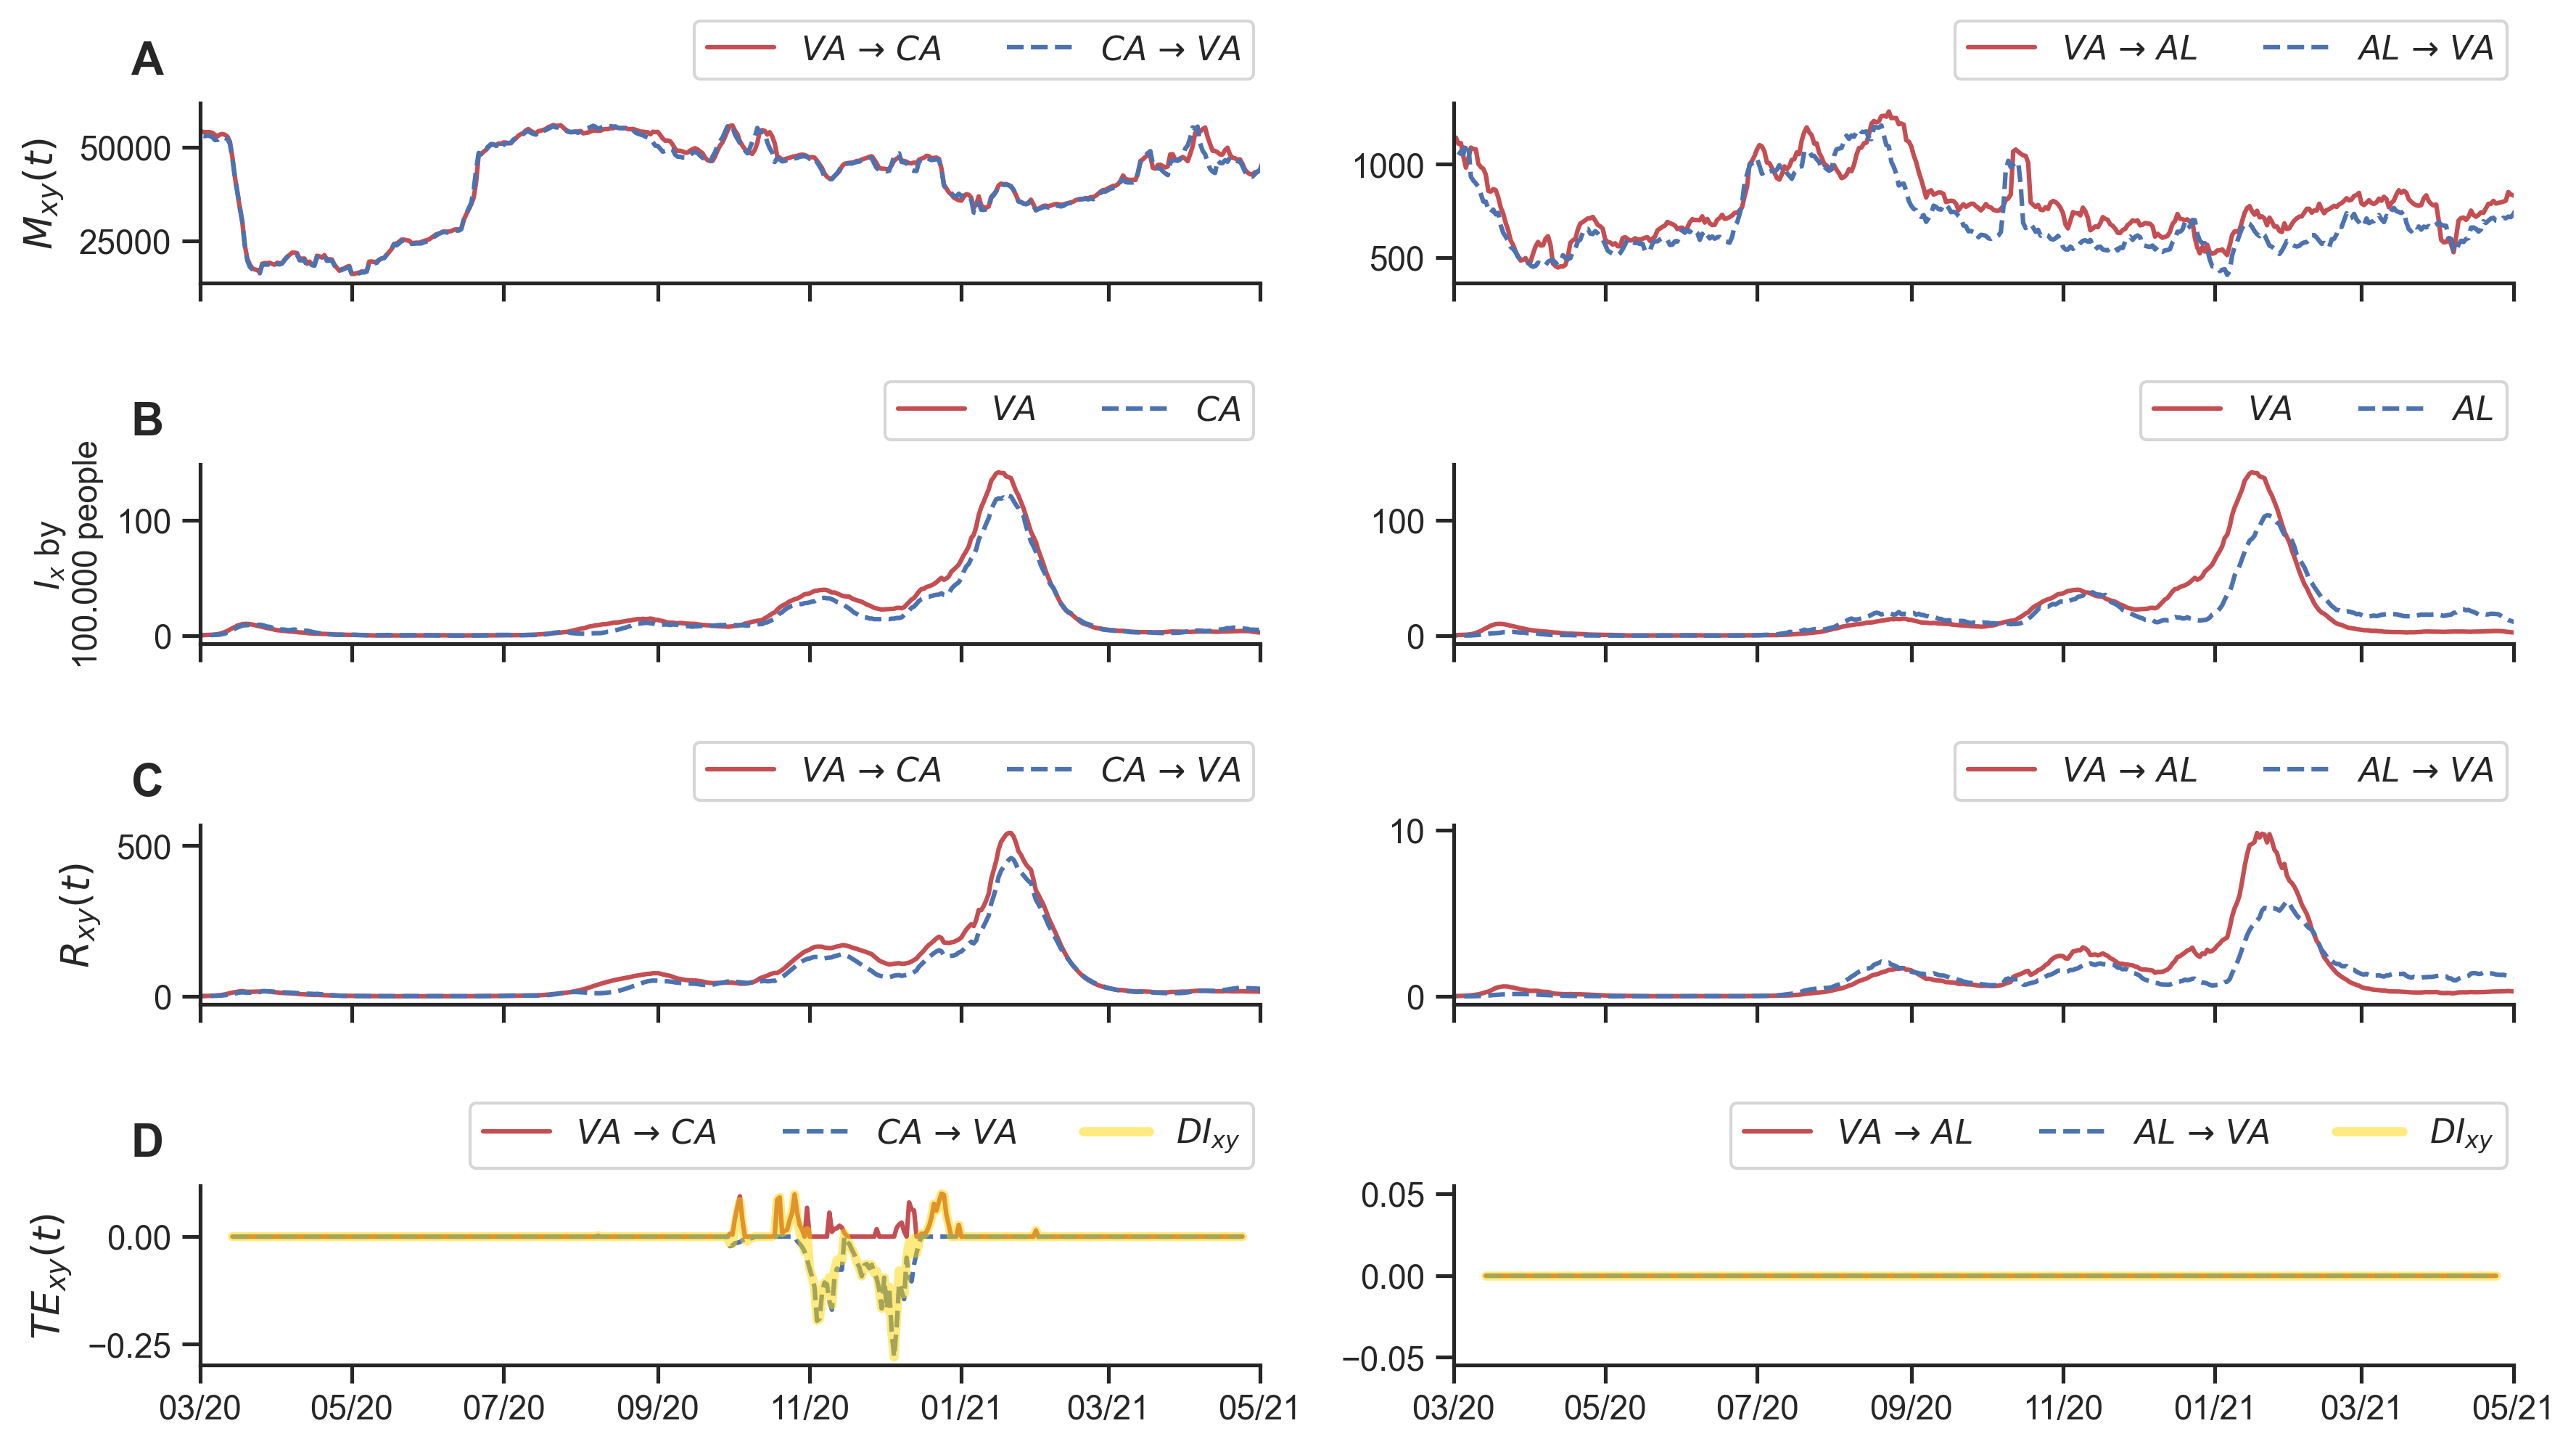

In [4]:
def plot_profiles(Txy, risk_ds, cases_ds, source, target, axes, ax_col, s_label=None, t_label=None, 
                  xoff=-0.065, yoff=1.35):
    
    plot_label_parms = dict(fontsize=15, verticalalignment='top', fontfamily='sans', weight='bold')
    legend_params = dict(loc="upper right", bbox_to_anchor=(1.01, 1.55))
    
    if s_label is None:
        s_label = source
    if t_label is None:
        t_label = target
    
    trips_ij = risk_ds['trips_ij'].loc[source, target, :].to_pandas()
    trips_ji = risk_ds['trips_ij'].loc[target, source, :].to_pandas()
    ax = axes[0, ax_col]
    ax.plot(trips_ij, 'r', label=f"${s_label}\ \u2192\ {t_label}$")
    ax.plot(trips_ji, 'b--', label=f"${t_label}\ \u2192\ {s_label}$")
    ax.legend(ncol=2, **legend_params)
    if ax_col == 0:
        ax.set_ylabel(r'$M_{xy}(t)$', fontsize=13)
        ax.text(xoff, yoff, "A", transform=ax.transAxes, **plot_label_parms)

    cases_i = cases_ds['new_cases_by_100k'].loc[source, :].to_pandas()
    cases_j = cases_ds['new_cases_by_100k'].loc[target, :].to_pandas()
    ax = axes[1, ax_col]
    ax.plot(cases_i, 'r', label=f"${s_label}$")
    ax.plot(cases_j, 'b--', label=f"${t_label}$")
    
    ax.legend(ncol=2, **legend_params)
    if ax_col == 0:
        ax.set_ylabel('$I_x$ by\n100.000 people', fontsize=11, multialignment='center')
        ax.text(xoff, yoff, "B", transform=ax.transAxes, **plot_label_parms)

    risk_ij = risk_ds['risk_ij'].loc[source, target, :].to_pandas()
    risk_ji = risk_ds['risk_ij'].loc[target, source, :].to_pandas()
    ax = axes[2, ax_col]
    ax.plot(risk_ij, 'r', label=f"${s_label}\ \u2192\ {t_label}$")
    ax.plot(risk_ji, 'b--', label=f"${t_label}\ \u2192\ {s_label}$")
    ax.legend(ncol=2, **legend_params)
    if ax_col == 0:
        ax.set_ylabel(r'${R}_{xy}(t)$', fontsize=13)
        ax.text(xoff, yoff, "C", transform=ax.transAxes, **plot_label_parms)

    te_ij = Txy.loc[source, target, :].to_pandas()
    te_ji = -1 * Txy.loc[target, source, :].to_pandas()
    DI_ij = te_ij+te_ji
    ax = axes[3, ax_col]
    ax.plot(te_ij, 'r', label=f"${s_label}\ \u2192\ {t_label}$")
    ax.plot(te_ji, 'b--', label=f"${t_label}\ \u2192\ {s_label}$")
    ax.plot(DI_ij, color="gold", linewidth=3, alpha=0.5, label=r'$DI_{xy}$')
    ax.legend(ncol=3, **legend_params)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))

    if ax_col == 0:
        ax.set_ylabel(r'${TE}_{xy}(t)$', fontsize=13)
        ax.text(xoff, yoff, "D", transform=ax.transAxes, **plot_label_parms)
        

    ax.set_xlim([datetime.date(2020, 3, 1), datetime.date(2021, 5, 1)])



custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", palette="deep", rc=custom_params)

fig, axes = plt.subplots(4,2, figsize=(12,7), sharex=True, dpi=300)
source = "28"; target = "19" 
s_label = "M"; t_label = "G"
plot_profiles(Txy, risk_ds, cases_ds, source, target, axes, 0, s_label=s_label, t_label=t_label)
source = "28"; target = "33" 
s_label = "M"; t_label = "A"
plot_profiles(Txy, risk_ds, cases_ds, source, target, axes, 1, s_label=s_label, t_label=t_label)
sns.despine(fig)
fig.tight_layout()
fig.savefig('../figures/main/Figure3.tiff', dpi=300)


fig, axes = plt.subplots(4,2, figsize=(12,7), sharex=True, dpi=300)
source = "08"; target = "17" 
s_label = "BCN"; t_label = "GI"
plot_profiles(Txy, risk_ds, cases_ds, source, target, axes, 0, s_label=s_label, t_label=t_label)
source = "08"; target = "07" 
s_label = "BCN"; t_label = "IB"
plot_profiles(Txy, risk_ds, cases_ds, source, target, axes, 1, s_label=s_label, t_label=t_label)
sns.despine(fig)
fig.tight_layout()
fig.savefig('../figures/supp/FigureS8.tiff', dpi=300)


fig, axes = plt.subplots(4,2, figsize=(12,7), sharex=True, dpi=300)
source = "46"; target = "12" 
s_label = "VA"; t_label = "CA"
plot_profiles(Txy, risk_ds, cases_ds, source, target, axes, 0, s_label=s_label, t_label=t_label)
source = "46"; target = "04" 
s_label = "VA"; t_label = "AL"
plot_profiles(Txy, risk_ds, cases_ds, source, target, axes, 1, s_label=s_label, t_label=t_label)
sns.despine(fig)
fig.tight_layout()
fig.savefig('../figures/supp/FigureS9.tiff', dpi=300)



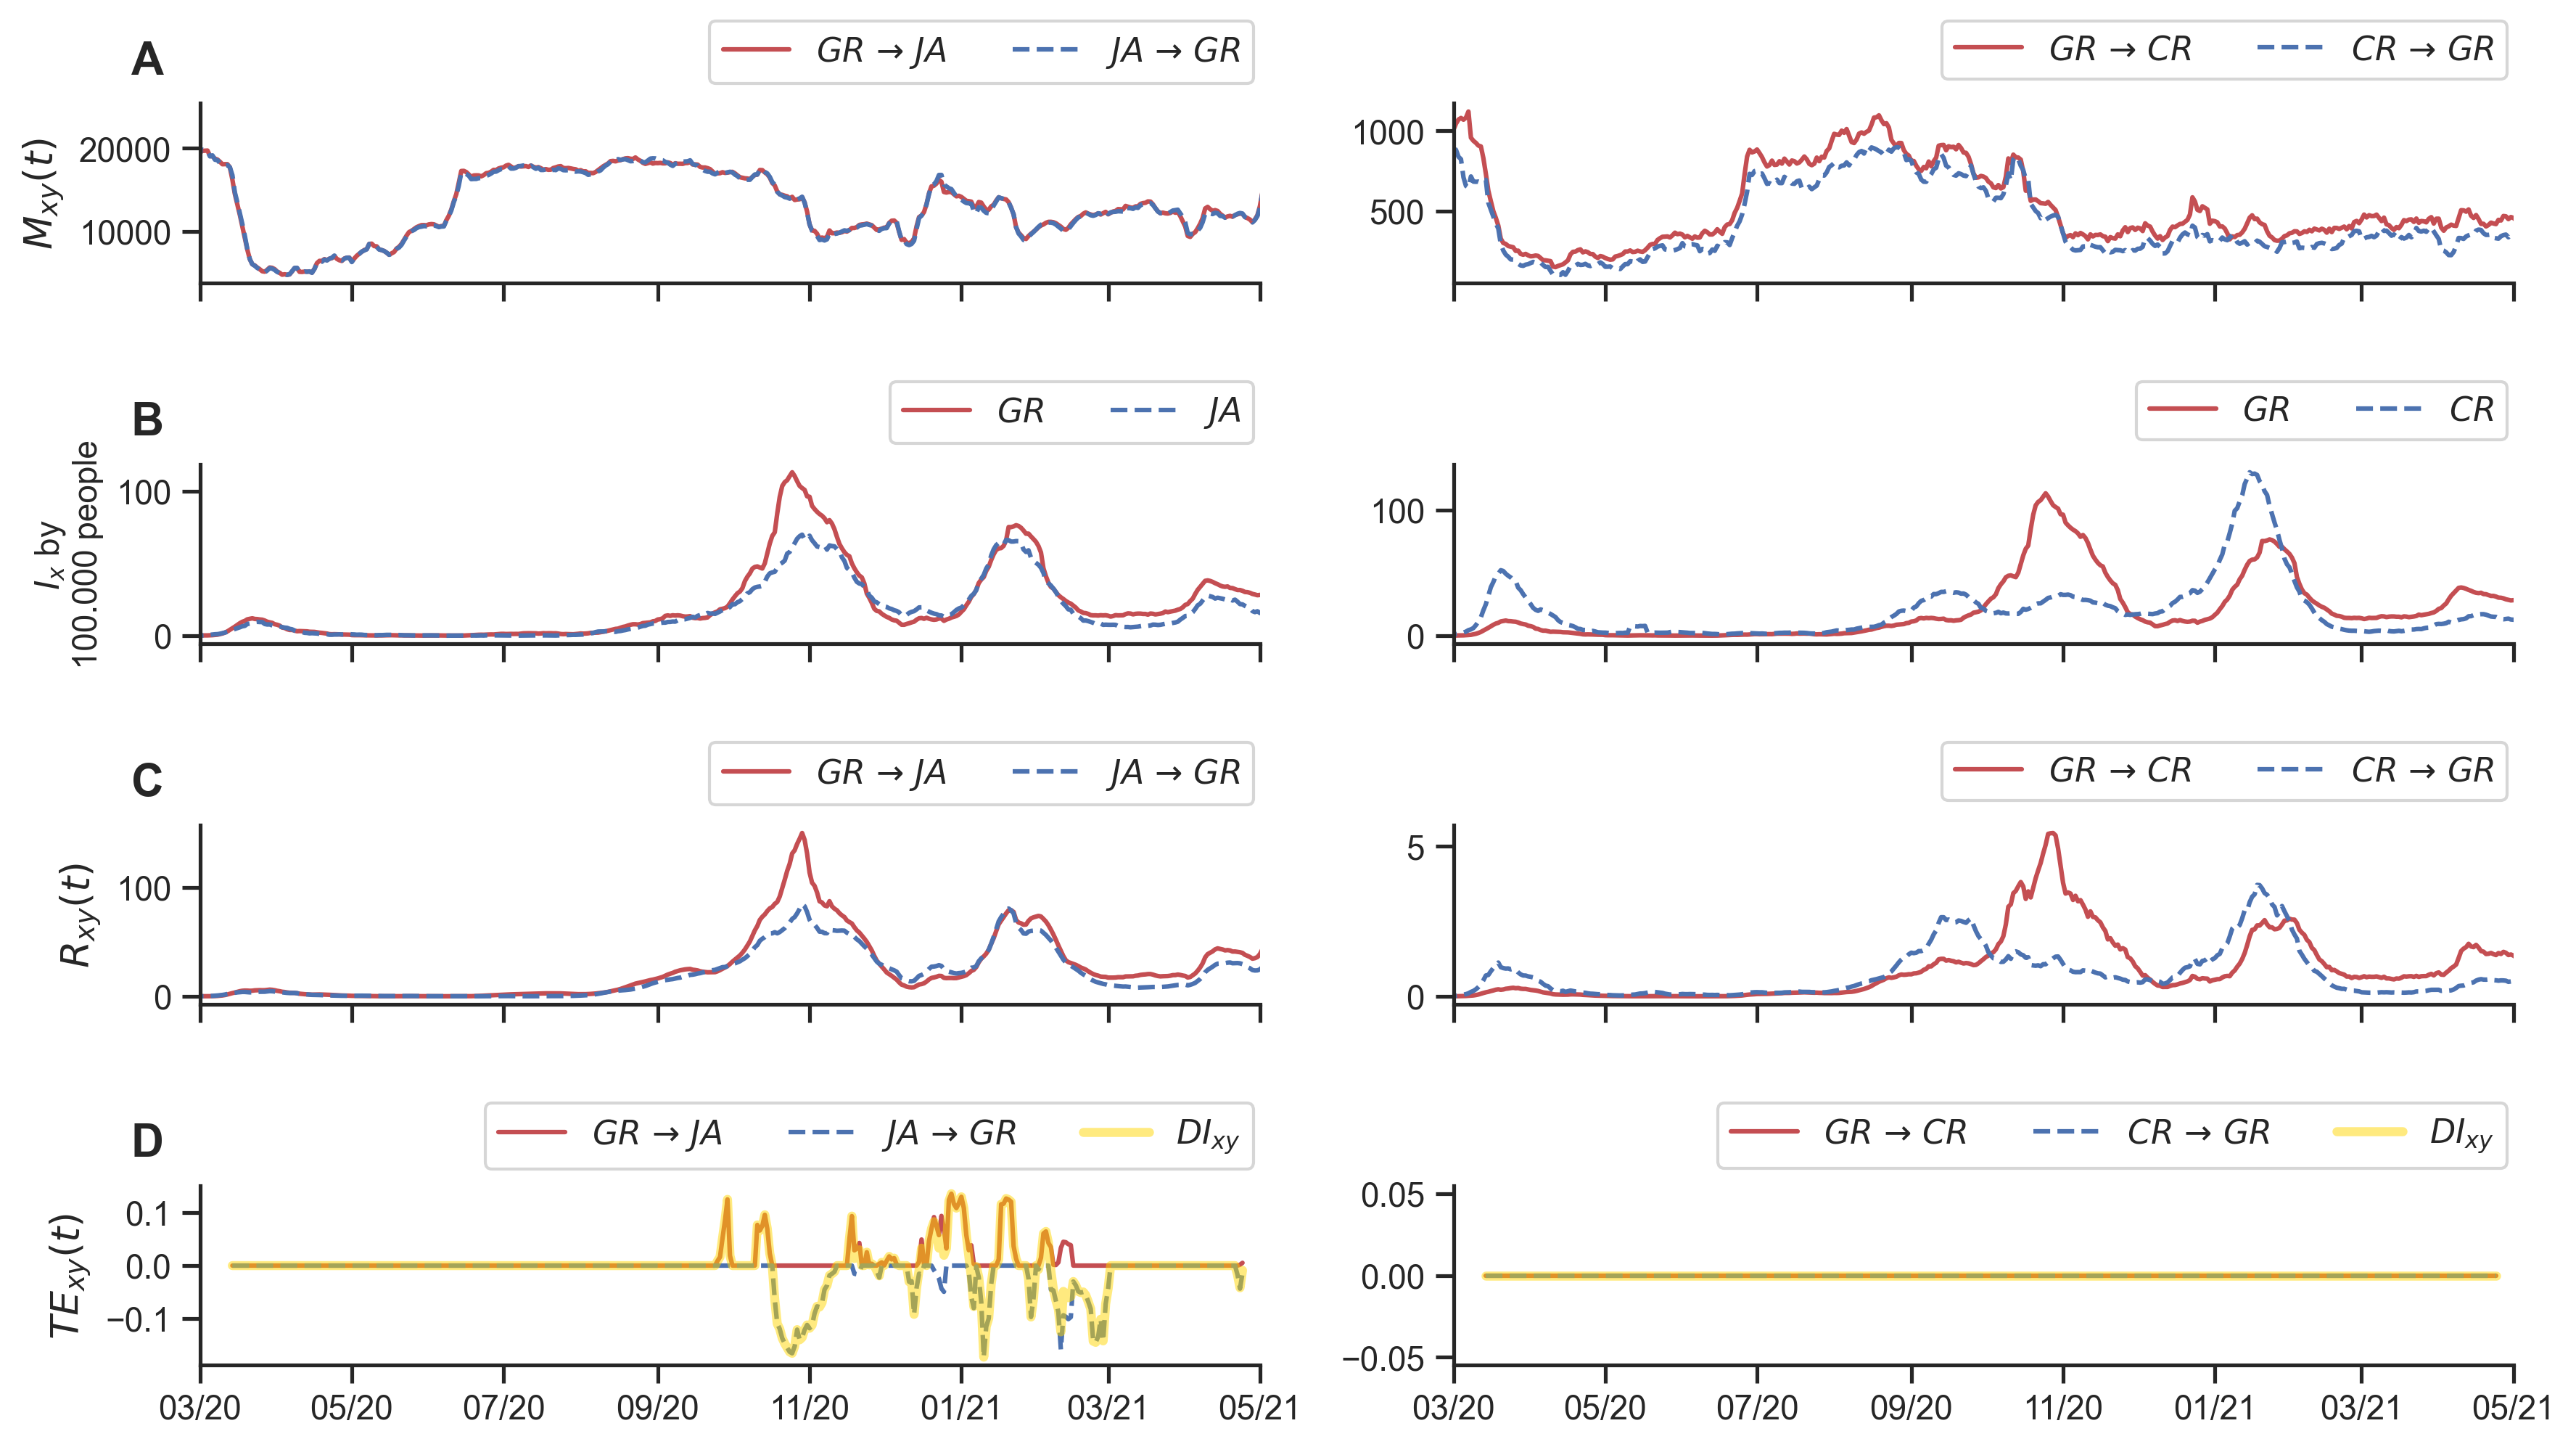

In [6]:
fig, axes = plt.subplots(4,2, figsize=(12,7), sharex=True, dpi=300)
source = "18"; target = "23" 
s_label = "GR"; t_label = "JA"
plot_profiles(Txy, risk_ds, cases_ds, source, target, axes, 0, s_label=s_label, t_label=t_label)
source = "18"; target = "13" 
s_label = "GR"; t_label = "CR"
# source = "18"; target = "11" 
# s_label = "GR"; t_label = "CZ"

plot_profiles(Txy, risk_ds, cases_ds, source, target, axes, 1, s_label=s_label, t_label=t_label)
sns.despine(fig)
fig.tight_layout()
fig.savefig('../figures/supp/FigureS10.tiff', dpi=300)
# fig.savefig('../figures/profiles_Granada_Jaen_Cadiz.png')

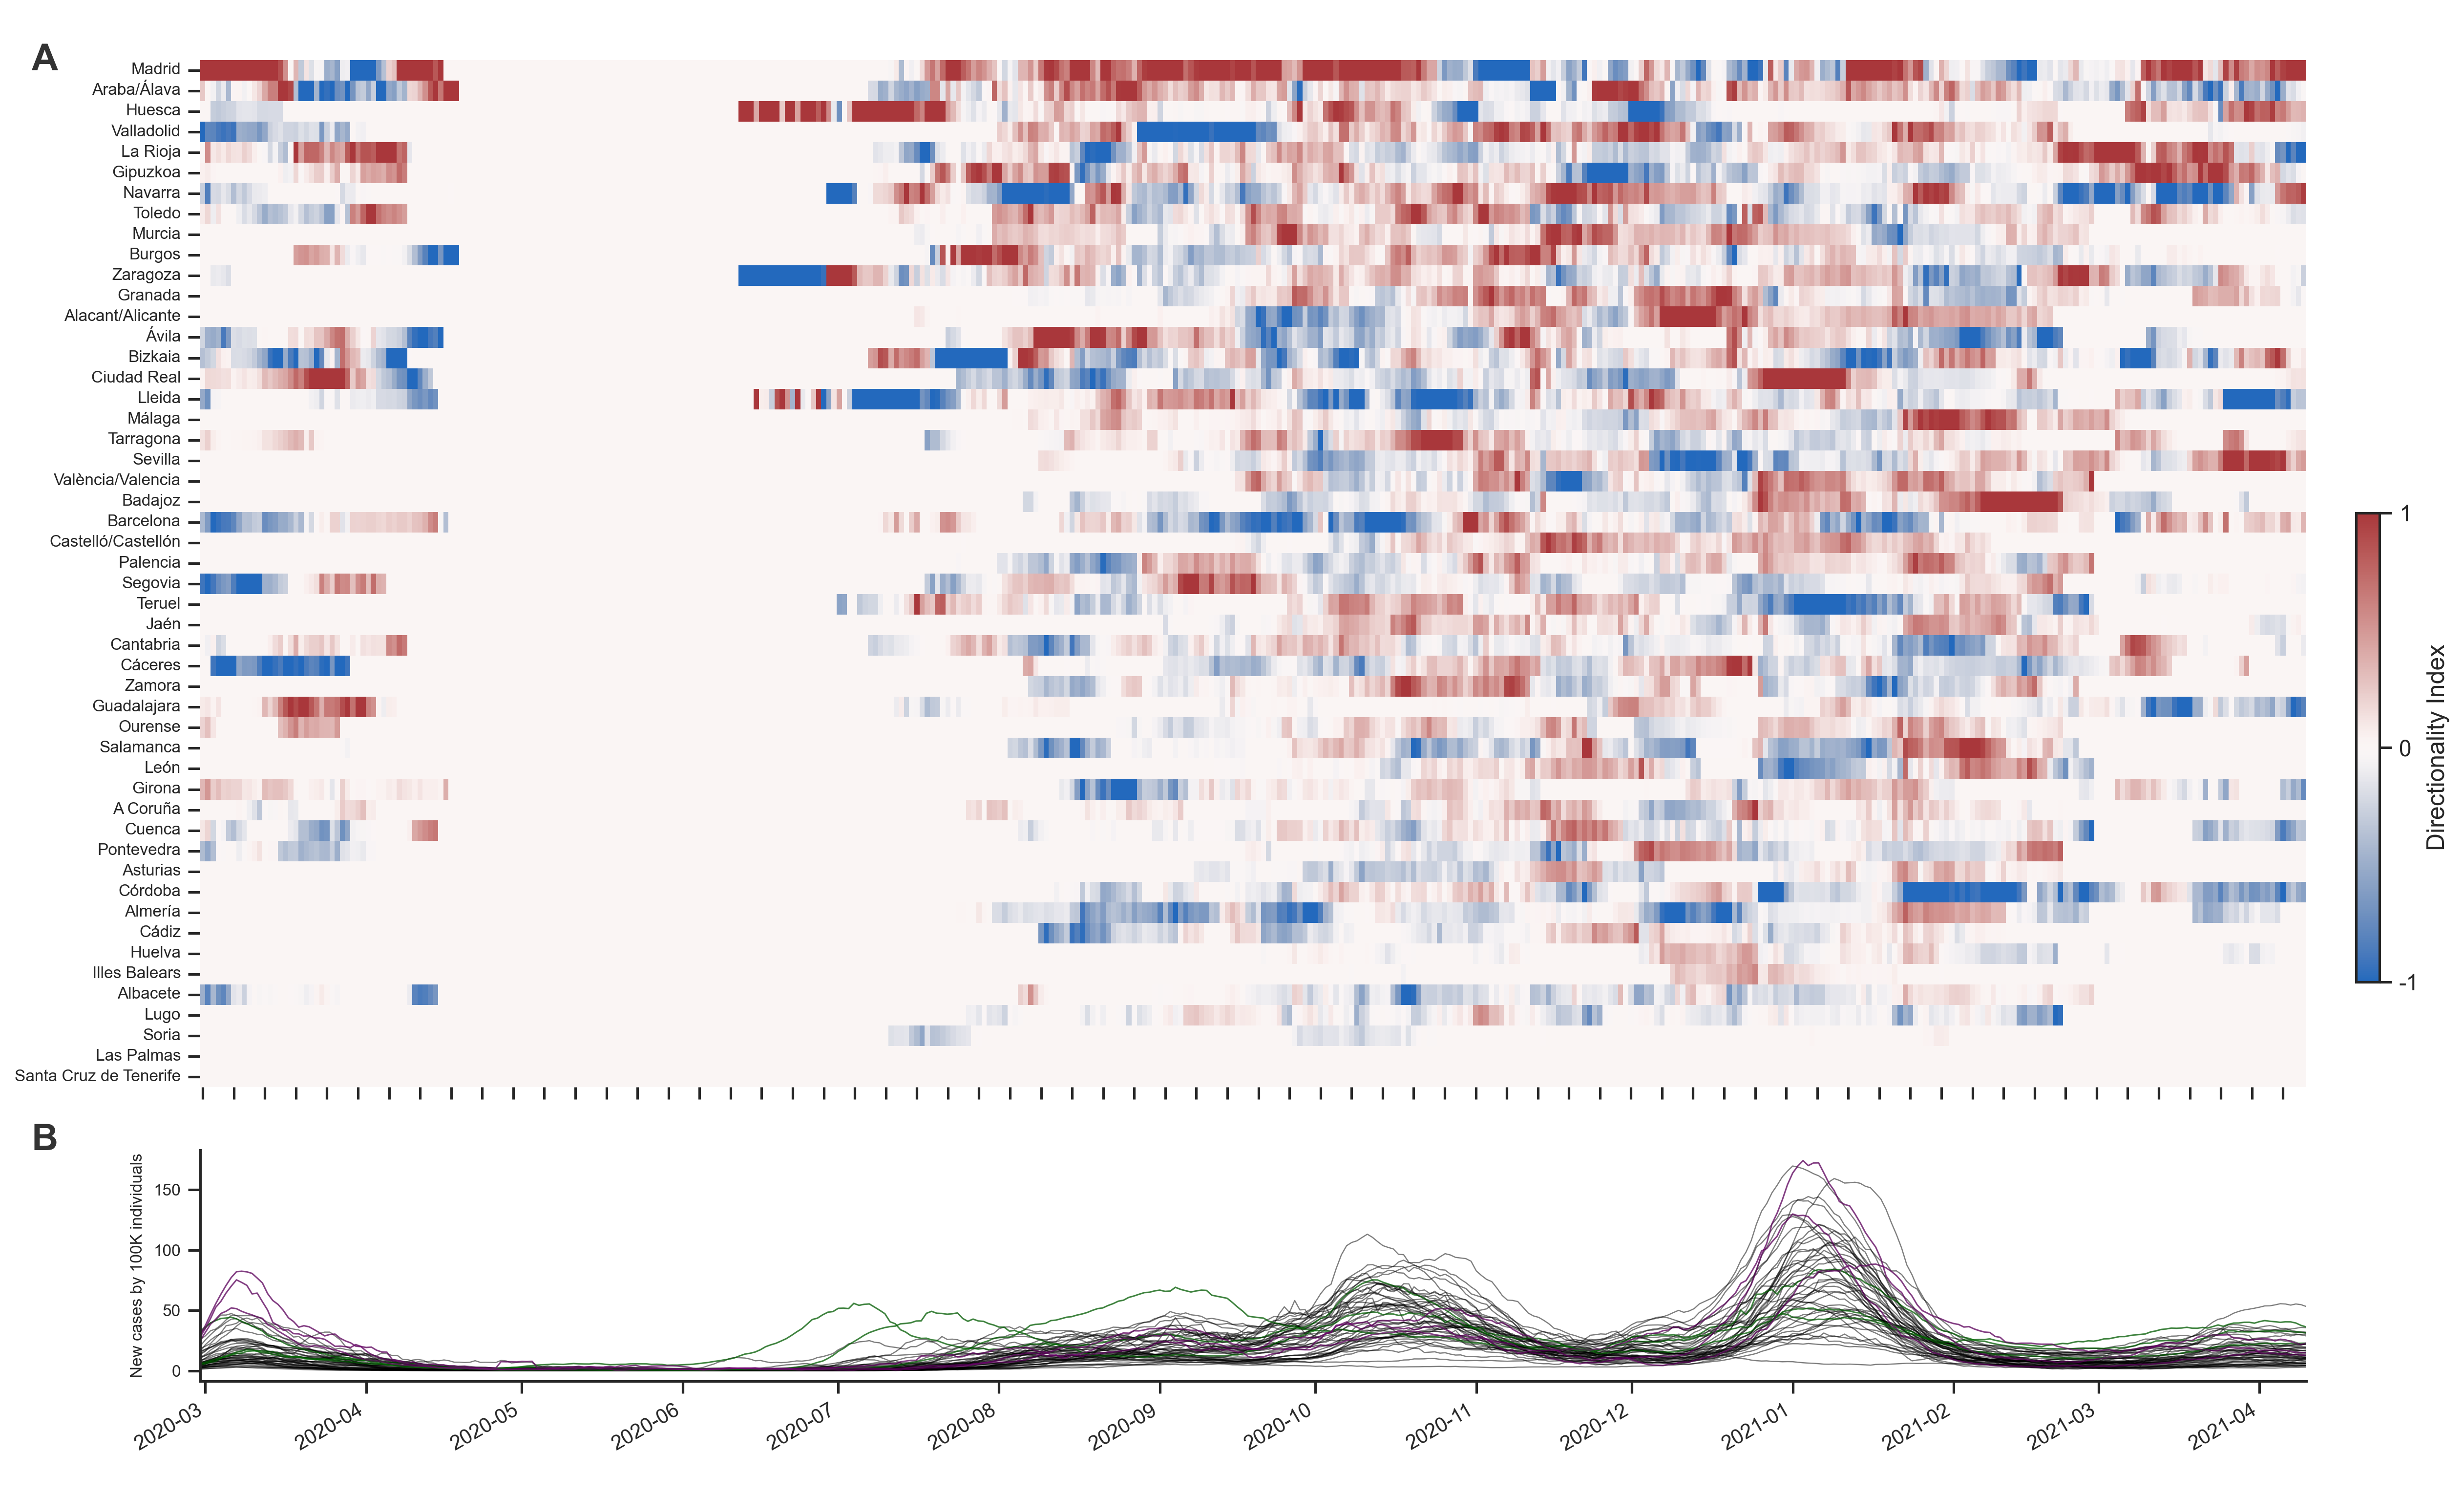

In [7]:
def plot_heatmap_cases(Txy, df_cases, prov_names, sort_values=True, scale_values=False, figsize=(32,18), linewidths=0.01, cmap=mpl.cm.bwr):
    if scale_values:
    	DIx = calculate_normalized_TSx(Txy)
    else:
        TSxy = calculate_TSxy(Txy)
        DIx = TSxy.sum("target")
    df_DIx = DIx.to_pandas()

    n = Txy.coords["date"].shape[0]
    m = Txy.coords["source"].shape[0]

    if m < 100:
        figsize = (16, 10)
        height_ratios = [6, 1.35]
    elif m < 500:
        figsize = (32, 70)
        height_ratios = [12, 1]
    
    fig, axes = plt.subplots(2,1, figsize=figsize, dpi=300, gridspec_kw={'height_ratios': height_ratios} )
    fig.set_facecolor('white')
    
    plot_heatmap(DIx, prov_names, sort_values=sort_values, ax=axes[0], linewidths=linewidths, cmap=cmap)
    axes[0].set_xticklabels([])
    
    df = df_cases.reset_index()
    for prov in prov_names.keys():
        sns.lineplot(data=df.loc[df.id==prov], x="date", y="new_cases_by_100k", ax=axes[1], color='black', linewidth=0.6, alpha=0.5)
    
    for prov in ["28", "25", "50"]:
        sns.lineplot(data=df.loc[df.id==prov], x="date", y="new_cases_by_100k", ax=axes[1], color='green', linewidth=0.8, alpha=0.5)
        
    for prov in ["40", "42", "13"]:
        sns.lineplot(data=df.loc[df.id==prov], x="date", y="new_cases_by_100k", ax=axes[1], color='purple', linewidth=0.8, alpha=0.5)
    axes[1].set_xlim((df_DIx.columns[0], df_DIx.columns[-1]))
    axes[1].set_ylabel("New cases by 100K individuals", fontsize=8)
    axes[1].tick_params(axis='both', which='major', labelsize=8)
    axes[1].tick_params(axis='x', which='major', labelsize=10)
    axes[1].xaxis.set_major_locator(mdates.MonthLocator(bymonthday=15))
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].set_xlabel("")


    axes[0].text(-0.08, 0.99, "A", fontsize=18, 
                        transform=axes[0].transAxes, weight='bold', color='#333333')
    axes[1].text(-0.08, 1.0, "B", fontsize=18,
                        transform=axes[1].transAxes, weight='bold', color='#333333')

    fig.autofmt_xdate()
    fig.tight_layout()
    
    return fig


fig = plot_heatmap_cases(DIxy, df_cases, prov_names, sort_values=True, scale_values=True, linewidths=0, cmap="vlag")
plt.subplots_adjust(hspace=0.1, wspace=0.1)

cbar_ax = fig.add_axes([0.97, 0.0, 0.05, 1])
cmap = sns.color_palette("vlag", as_cmap=True)
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
                    fraction=0.2, pad=0.0, ax=cbar_ax, ticks=[-1, 0, 1])

cbar.set_label("Directionality Index", loc='center')
cbar.ax.set_yticklabels(['-1', '0', '1'])
cbar_ax.set_axis_off()

fig.savefig("../figures/main/Figure4.tiff", dpi=300)

In [16]:
def plot_top_k(Txy, risk_ds, cases_ds, prov_names, relation, reference, k, max_te, max_risk, date_range):
    m = 10
    n = int( (k+1) * 1.5 )
    trimed_Txy = Txy.loc[:,:,f"2020-{date_range[0]}-01":f"2020-{date_range[1]}-30"]
    trimed_dates = trimed_Txy.coords['date'].values

    figsize = (m,n)
    fig, axes = plt.subplots((k+1), 1, figsize=figsize, dpi=100, sharex=True)
    fig.set_facecolor('white')

    agg_by = 'sum'
    top_k =  get_top_related(reference, trimed_Txy, k=k, agg_by=agg_by, relation=relation)

    for i,related in enumerate(top_k):  
        ax = axes[i]
        var_name = r'$TE_{xy}$'
    
        if relation == "source":
            ts = Txy.loc[related, reference, trimed_dates].to_pandas()
        elif relation == "target":
            ts = Txy.loc[reference, related, trimed_dates].to_pandas()
        
        ts = pd.DataFrame(ts, columns=[var_name])
    
        sns.lineplot(x="date", y=var_name, data=ts, ax=ax, color='r', label=r"$DI_{xy}^+(t)$")
        ax.set_ylabel(r"$DI_{xy}^+(t)$")
        ax.legend(loc=2)
        # ax.set_ylim(0,max_te)
        
        ax = ax.twinx()
        var_name = "risk_ij"
        if relation == "source":
            ts = risk_ds[var_name].loc[related, reference, trimed_dates].to_pandas()
        elif relation == "target":
            ts = risk_ds[var_name].loc[reference, related, trimed_dates].to_pandas()
        ts = pd.DataFrame(ts, columns=[var_name])
        ts = ts.rolling(21, min_periods=1).sum()
        sns.lineplot(x="date", y=var_name, data=ts, ax=ax, color='b', label=r"$R_{xy}(t)$"+" from"+f" {prov_names[related]}")
        ax.set_ylabel(r"${R}_{xy}(t)$")
        ax.legend(loc=1)
        ax.set_ylim(0,max_risk)

    ax = axes[-1]
    ts = cases_ds['new_cases_by_100k'].loc[reference, trimed_dates].to_pandas()
    ax.fill_between(ts.index, ts.values, color='grey', alpha=0.2)
    ax.plot(ts.index,ts.values, c='black')
    ax.set_ylabel(r'$I_y(t)$')

    for i in range(len(axes)):
        ax = axes[i]
        ax.text(-0.09, 1.08, string.ascii_uppercase[i], fontsize=14, transform=ax.transAxes, weight='bold', color='#333333')

    ax.set_xlim([datetime.date(2020,int(date_range[0]),30), datetime.date(2020,int(date_range[1]),30)])
    axes[0].set_title(f"Top-{k} TE {relation}s for {prov_names[reference]}")
    axes[3].set_title(f"New cases by 100k inhabitants for {prov_names[reference]}")
    axes[3].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    axes[3].xaxis.set_major_formatter(mdates.DateFormatter("%m/%y"))
    fig.tight_layout()

    return fig

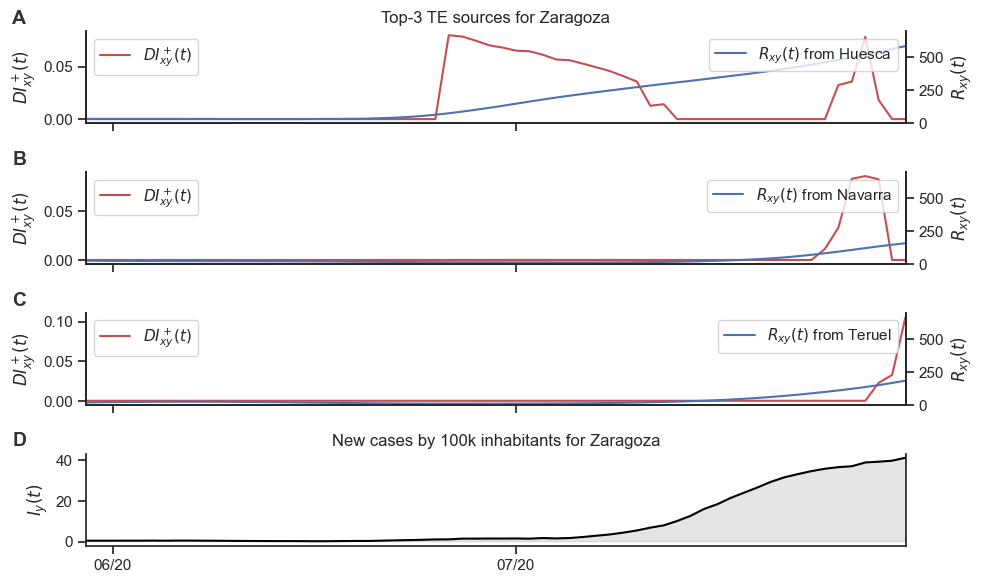

In [23]:
# if relation == source --> return top_k_sources for reference
# if relation == target --> return top_k_targets for reference

relation = "source"
reference = "50"

custom_params = {"axes.spines.top": False}
sns.set_theme(style="ticks", palette="deep", rc=custom_params)
 
k = 3
DIxy = calculate_net_TSxy(Txy)

date_range = ("05","07")
fig = plot_top_k(DIxy, risk_ds, cases_ds, prov_names, relation, reference, k, 1.1, 700, date_range)
fig.savefig("../figures/supp/FigureS11.tiff", dpi=300)

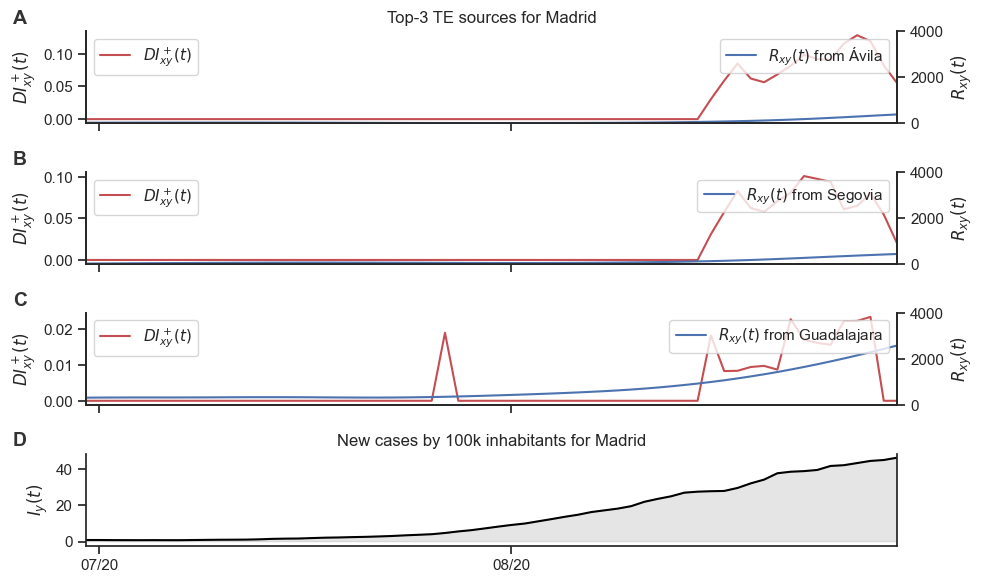

In [24]:
relation = "source"
reference = "28"

custom_params = {"axes.spines.top": False}
sns.set_theme(style="ticks", palette="deep", rc=custom_params)
 
k = 3
DIxy = calculate_net_TSxy(Txy)

date_range = ("06","08")
fig = plot_top_k(DIxy, risk_ds, cases_ds, prov_names, relation, reference, k, 1, 4000, date_range)
fig.savefig("../figures/supp/FigureS12.tiff", dpi=300)